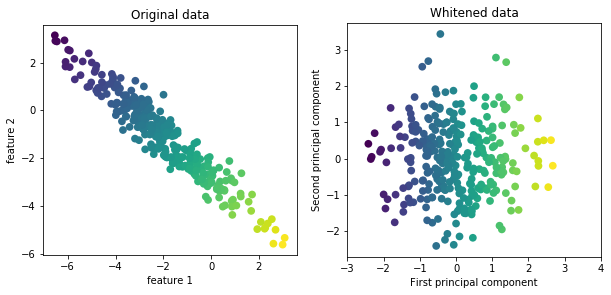

In [21]:
import mglearn
mglearn.plots.plot_pca_whitening()

### Eigenfaces
Eigenfaces are the set of features in the form of vector (i.e. eigenvectors) that denotes the variation between faces. They are the weighted sum of the some component of faces. A set of eigenfaces can be generated by performing PCA on a large set of images depicting different human faces. Any human faces can be considered as linear combination of the components.

Eigenfaces are generated using PCA as below:
1. The training set is taken and are normalized (whitened).
2. The eigenvectors of the covariance matrix of the face image are extracted.
3. Eigenvectors are formed by converting the image matrix into vector form and the vector should satisfy the eigenvalue equation.

### $\textbf{k}$-nearest Neighbours Algorithm
$k$-nearest Neighbours Algorithm is a supervised learning algorithm that classifies the given data by comparing with the $k$ nearest neighbors in the existing data set.

The algorithm can be summarized as below:
1. Choose the number of neighbors k and a distance metric
    * We will use the Euclidean distance, which is a Minkowski distance with $p=2$ (i.e. root of the sum of squares of each difference between two points, based on the Pythagorean formula).
    * $d(x^{(i)},x^{(j)})=\left.\sqrt[p]{\sum_{k} |𝑥^{(i)}_k-x^{(j)}_k|^p} \right |_{p=2}$
2. Find the $k$ nearest neighbors from the existing data set.
3. Assign the class determined by the majority. 
    * The majority will be weighted by inverse of the distance.
![](knearest.png)

### Support Vector Machine
Suport Vector machine is another supervised learning algorithm that can be used for classifying data. The algorithm classifies the given data by creating planes that separates each class. The planes are created such that they maximize the margin between different classes (optimal hyperplanes).

We maximize the distance to the nearest training data points of any class because doing so lowers the classification error.
The test points or query points are then mapped into that same space and predicted to belong to a category based on which side of the gap they fall on.

In Python, the Gamma parameter defines how far the influence of a single training example reaches, with low values meaning 'far' and high values meaning 'close'.

The C parameter trades off misclassification of training examples against simplicity of the decision surface. A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly by giving the model freedom to select more samples as support vectors.
![](svm.png)

## Experiment

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools

from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

plt.rcParams['image.cmap'] = "gray"

First, we fetch faces from the Labeled Faces in the Wild dataset.

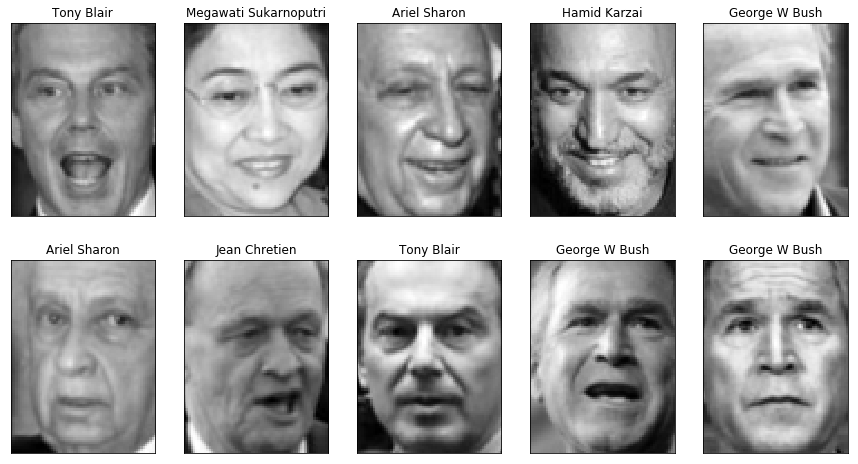

In [3]:
people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
image_shape = people.images[0].shape

fig, axes = plt.subplots(2, 5, figsize=(15, 8),
                         subplot_kw={'xticks': (), 'yticks': ()})
for target, image, ax in zip(people.target, people.images, axes.ravel()):
    imshow = ax.imshow(image, cmap=None)
    ax.set_title(people.target_names[target])

In [4]:
print("people.images.shape: {}".format(people.images.shape))
print("Number of classes: {}".format(len(people.target_names)))

people.images.shape: (2530, 87, 65)
Number of classes: 45


There are 2,530 images, with each 87×65 pixels large, belonging to 45 different people.

In [5]:
# count how often each target appears
counts = np.bincount(people.target)
# print counts next to target names:
for i, (count, name) in enumerate(zip(counts, people.target_names)):
    print("{0:25} {1:3}".format(name, count), end='   ')
    if (i + 1) % 3 == 0:
        print()

Alejandro Toledo           39   Alvaro Uribe               35   Amelie Mauresmo            21   
Andre Agassi               36   Ariel Sharon               77   Atal Bihari Vajpayee       24   
Bill Clinton               29   Colin Powell              236   David Beckham              31   
Donald Rumsfeld           121   George Robertson           22   George W Bush             530   
Gerhard Schroeder         109   Gloria Macapagal Arroyo    44   Gray Davis                 26   
Hamid Karzai               22   Hans Blix                  39   Hugo Chavez                71   
Igor Ivanov                20   Jack Straw                 28   Jacques Chirac             52   
Jean Chretien              55   Jennifer Aniston           21   Jennifer Capriati          42   
Jennifer Lopez             21   John Ashcroft              53   Juan Carlos Ferrero        28   
Junichiro Koizumi          60   Kofi Annan                 32   Laura Bush                 41   
Lindsay Davenport          22 

As data seems to be too skewed towards George W Bush and Colin Powell, we will only take up to 50 per person.

In [6]:
# data too skewed, take 50 per person
mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1

X_people = people.data[mask]
y_people = people.target[mask]

# rescale the grey-scale values to be between 0 and 1
X_people = X_people / 255

In [7]:
# split the data in training and test set
X_train, X_test, y_train, y_test = train_test_split(
    X_people, y_people, stratify=y_people, random_state=0)
# build a KNeighborsClassifier with using one neighbor:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
print("Test set score of 1-nn: {:.2f}".format(knn.score(X_test, y_test)))


Test set score of 1-nn: 0.24


$K$-nearest Neighbours Algorithm itself can yield 24% of accuracy. Let's see what it can do with PCA.<br>
The principal components can be seen below:

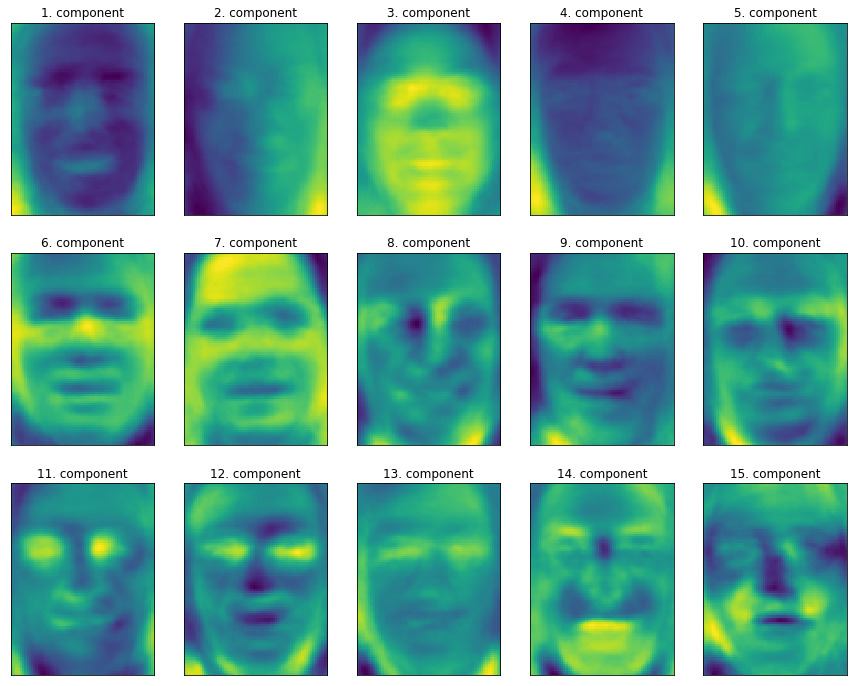

In [8]:
pca = PCA(n_components=100, whiten=True, random_state=0).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

fig, axes = plt.subplots(3, 5, figsize=(15, 12),
                         subplot_kw={'xticks': (), 'yticks': ()})
for i, (component, ax) in enumerate(zip(pca.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape),
              cmap='viridis')
    ax.set_title("{}. component".format((i + 1)))

While they don't resemble how humans perceive other people's faces, they do seem to figure out some distinguishing features, such as shape of eyes, noses, chins, and cheekbones.

### Comparing KNN and SVM
For $k$-nearest Neighbours Algorithm, we will use $k$ from 1 to 14.

k    acc.

 1   0.3715   
 2   0.3715   
 3   0.3817   
 4   0.3715   
 5   0.3791   
 6   0.3842   
 7   0.3766   
 8   0.3766   
 9   0.3664   
10   0.3562   
11   0.3486   
12   0.3588   
13   0.3562   
14   0.3562   


Text(0,0.5,'Accuracy')

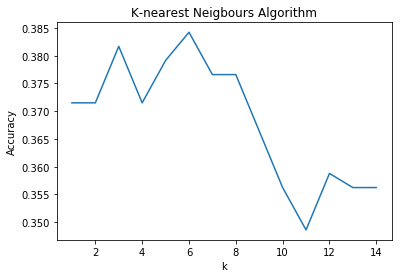

In [9]:
k = np.arange(1, 15, 1)
score = np.zeros(14)
print("k    acc.\n")
for i in range(len(k)):
    knn = KNeighborsClassifier(n_neighbors=k[i], weights='distance')
    knn.fit(X_train_pca, y_train)
    score[i] = knn.score(X_test_pca, y_test)
    print("{:2d}   {:.4f}".format(k[i], knn.score(X_test_pca, y_test)), end='   \n')
fig = plt.figure()
plt.plot(k, score, '-')
plt.title('K-nearest Neigbours Algorithm')
plt.xlabel('k')
plt.ylabel('Accuracy')

Changing $k$ doesn't seem to affect the accuracy significantly. The maximum accuracy is 38.42% with $k=6$.

For SVM, we will use varied values of C from 1 to 100 and Gamma from 0.0001 to 0.01, as seem below:

  c    .0001    .0003    .001     .003     .01

  1   0.0305   0.0305   0.2774   0.4504   0.5522   

  3   0.0305   0.2621   0.4962   0.5725   0.5852   

  5   0.0509   0.3893   0.5598   0.5802   0.5878   

 10   0.2977   0.5064   0.5725   0.5852   0.5878   

 30   0.5064   0.5649   0.5547   0.5852   0.5878   

 50   0.5496   0.5394   0.5547   0.5852   0.5878   

100   0.5598   0.5420   0.5522   0.5852   0.5878   



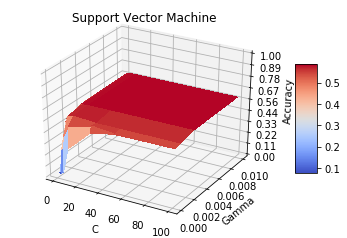

In [10]:
c = [1,3,5,10,30, 50,100]
gamma = [0.0001, 0.0003, 0.001, 0.003, 0.01]
score = np.zeros((7,5))
print("  c    .0001    .0003    .001     .003     .01\n")
for i in range(len(c)):
    print("{:3d}".format(c[i]), end='   ')
    for j in range(len(gamma)):
        svc = SVC(C=c[i], gamma=gamma[j])
        svc.fit(X_train_pca, y_train)
        score[i][j] = svc.score(X_test_pca, y_test)
        print("{:.4f}".format(score[i][j]), end='   ')
    print("\n")
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_title('Support Vector Machine')
ax.set_xlabel('C')
ax.set_ylabel('Gamma')
ax.set_zlabel('Accuracy')

c, gamma = np.meshgrid(c, gamma)
# Plot the surface.
surf = ax.plot_surface(c , gamma, np.transpose(score), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(0,1)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

Higher values of C and Gamma improve the algorithm, with maximum accuracy is 58.78% at $c=100$ and $gamma=0.01$.

### Confusion Matrix
We can use confusion matrix and classification report to delve a little deeper into the performance on a per class basis:

In [11]:
# Code adapted from scikit-learn docs
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    fig = plt.figure()
    fig.set_figheight(20)
    fig.set_figwidth(20)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm2 = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        cm2 = cm

    thresh = cm.max() * 0.50
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, int(cm2[i, j]*100+0.5),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

                         precision    recall  f1-score   support

       Alejandro Toledo       0.80      0.40      0.53        10
           Alvaro Uribe       0.25      0.11      0.15         9
        Amelie Mauresmo       0.50      0.20      0.29         5
           Andre Agassi       0.56      0.56      0.56         9
           Ariel Sharon       0.39      0.54      0.45        13
   Atal Bihari Vajpayee       0.80      0.67      0.73         6
           Bill Clinton       0.44      0.57      0.50         7
           Colin Powell       0.47      0.69      0.56        13
          David Beckham       0.33      0.12      0.18         8
        Donald Rumsfeld       0.41      0.54      0.47        13
       George Robertson       1.00      0.40      0.57         5
          George W Bush       0.54      1.00      0.70        13
      Gerhard Schroeder       0.46      0.85      0.59        13
Gloria Macapagal Arroyo       0.83      0.91      0.87        11
             Gray Davis 

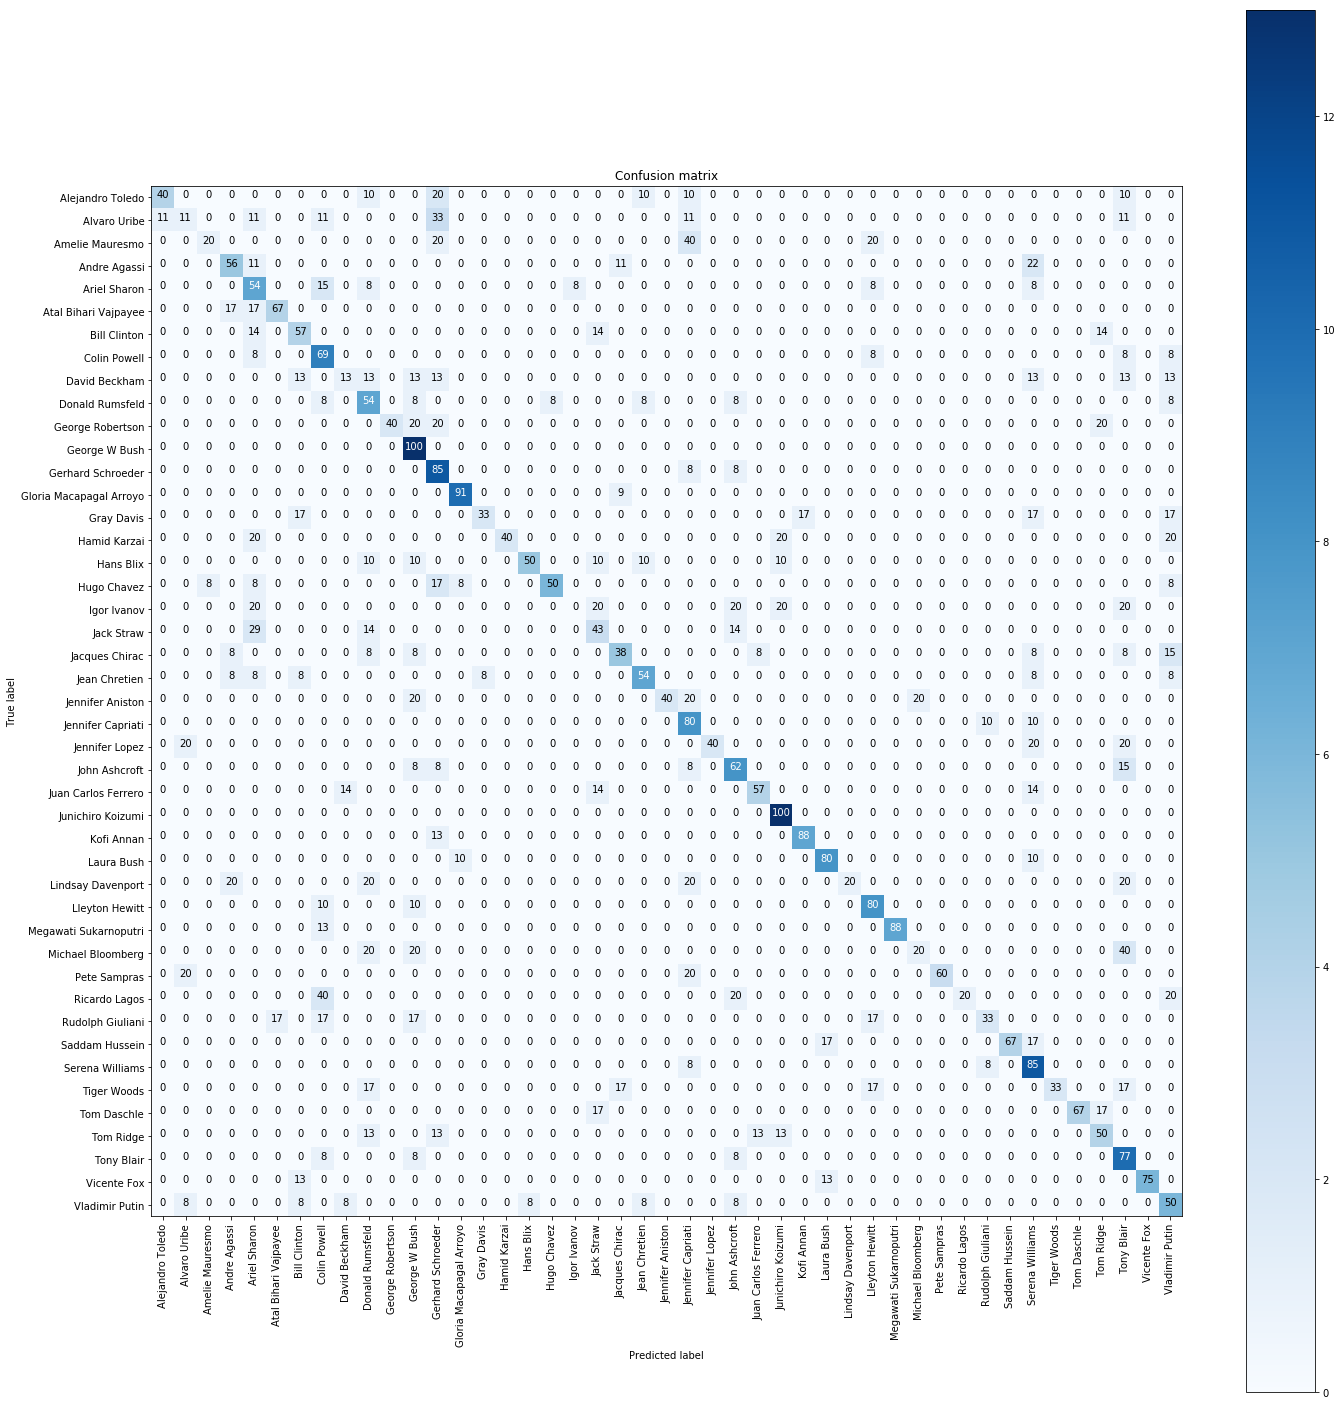

In [12]:
# svc with c=100 and gamma = 0.01
y_pred=svc.predict(X_test_pca)

cm=confusion_matrix(people.target_names[y_test], people.target_names[y_pred], labels=people.target_names)
plot_confusion_matrix(cm,people.target_names,normalize=True)
print(classification_report(y_test, y_pred, target_names=people.target_names))

Looks like there are some cases where Ricardo Lagos is misclassified as Colin Powell, Michael Bloomberg as Tony Blair and Amelie Mauressimo as Jennifer Capriati.

In [13]:
def show_misclassified(row_total, col_total, test, pred=-1, notpred=False):
    fig = plt.figure()
    fig.set_figheight(4*row_total)
    fig.set_figwidth(3*col_total)
    # set pred = -1 to show all faces from a person from test
    # set notpred = True to set filter to NOT equal pred
    if pred == -1:
        print('All faces of ' + people.target_names[test] + ':')
        filter = (y_test==test)
    elif notpred:
        if test == pred:
            print('Faces of ' + people.target_names[test] + ' misclassified:')
        else:
            print('Faces of ' + people.target_names[test] + ' NOT classifed as ' + people.target_names[pred] + ':')
        filter = (y_test==test) & (y_pred != pred)
    else:
        if test == pred:
            print('Faces of ' + people.target_names[test] + ' classified correctly:')
        else:
            print('Faces of ' + people.target_names[test] + ' misclassified as ' + people.target_names[pred] + ':')
        filter = (y_test==test) & (y_pred == pred)
    misclassified = X_test[filter]
    total = sum(filter)
    for row, col in itertools.product(range(row_total), range(col_total)):
        ind = row*col_total + col
        if ind < total:
            ax = plt.subplot2grid((row_total, col_total), (row, col))
            ax.axis('off')
            ind = row*col_total + col
            ax.set_title(people.target_names[test])
            ax.imshow(misclassified[ind].reshape(87,65),cmap='gray')
    plt.tight_layout()

Faces of Ricardo Lagos misclassified as Colin Powell:
Faces of Ricardo Lagos NOT classifed as Colin Powell:
All faces of Colin Powell:


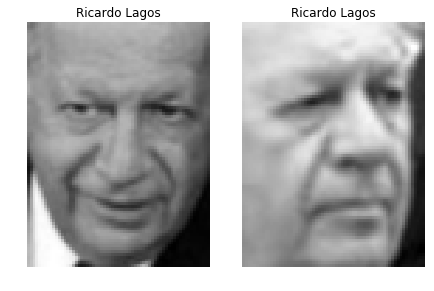

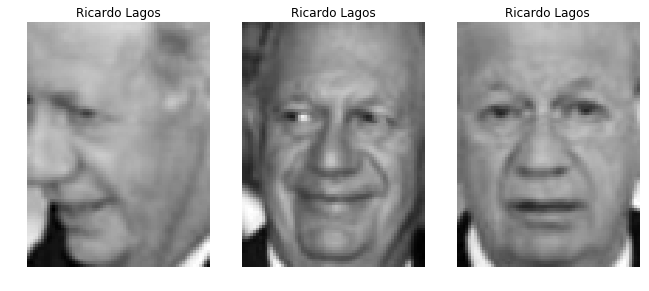

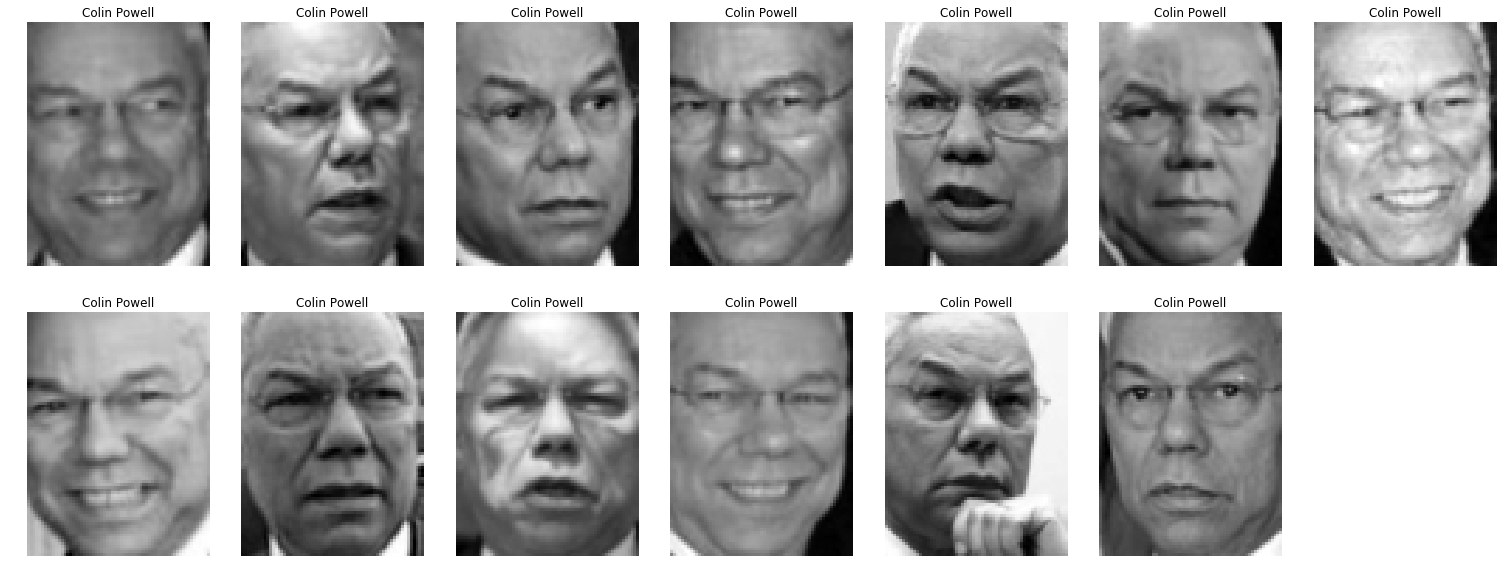

In [14]:
show_misclassified(4, 7, 35, 7)
show_misclassified(4, 7, 35, 7, True)
show_misclassified(4, 7, 7)

While Lagos and Powell do look similar, there aren't significant differences between those who were clasified as Powell and those who weren't. As Lagos performed quite badly (20%), let's see those faces that were classified correctly.

Faces of Ricardo Lagos classified correctly:


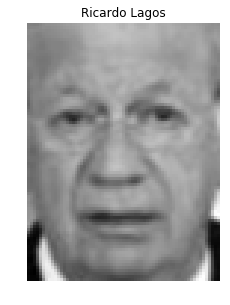

In [15]:
show_misclassified(4, 7, 35, 35)

The one photo that were classified correctly has glasses that distinguished the photo from the others. Also, the other photos tend to be aligned poorly.

Let's look at Bloomberg and Blair.

Faces of Michael Bloomberg misclassified as Tony Blair:
Faces of Michael Bloomberg NOT classifed as Tony Blair:
All faces of Tony Blair:


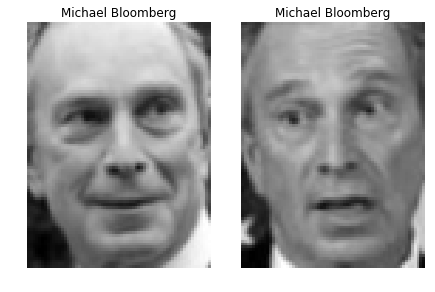

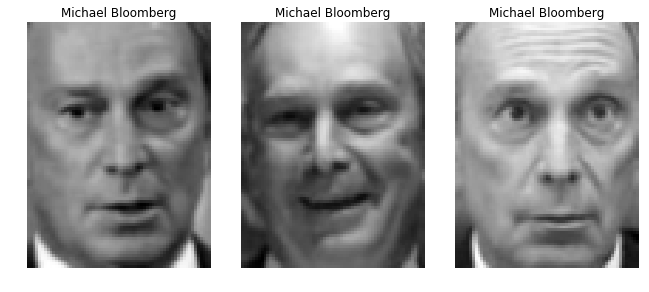

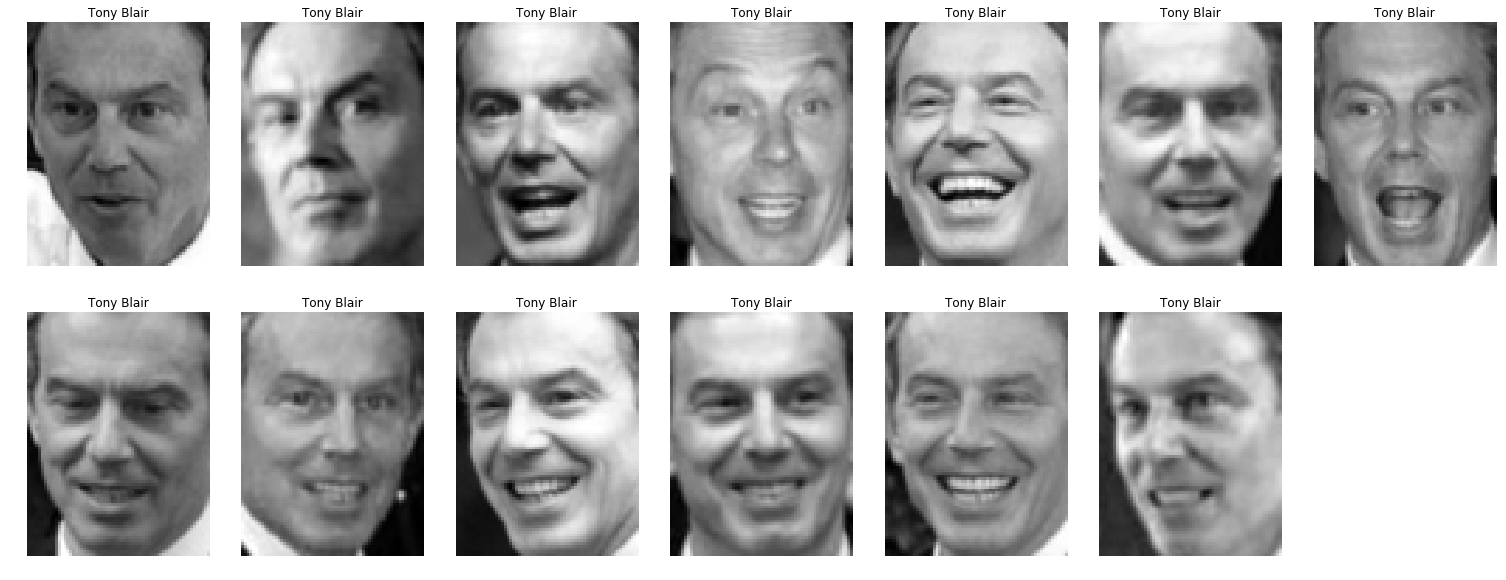

In [16]:
show_misclassified(4, 5, 33, 42)
show_misclassified(4, 5, 33, 42, True)
show_misclassified(4, 7, 42)

Again, they do seem to look alike a lot, especially in such a low resolution and monochrome photos.

Bloomberg also has an accuracy of 20%

Faces of Michael Bloomberg classified correctly:


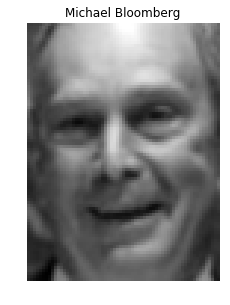

In [17]:
show_misclassified(4, 5, 33, 33)

Looks like the shades helped him classified correctly.

Faces of Amelie Mauresmo misclassified as Jennifer Capriati:
Faces of Amelie Mauresmo NOT classifed as Jennifer Capriati:
All faces of Jennifer Capriati:


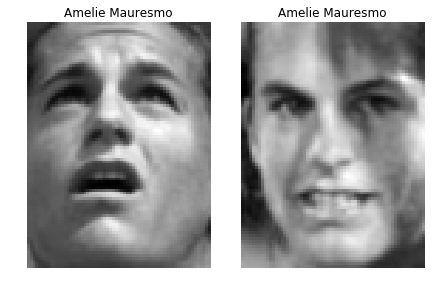

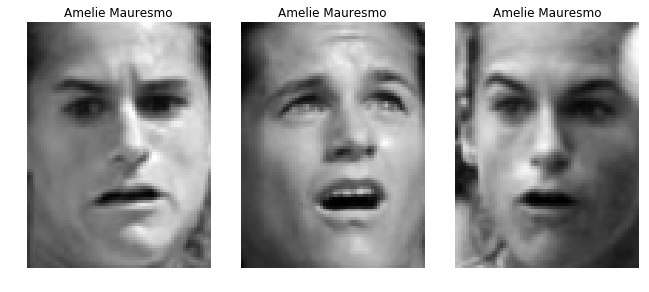

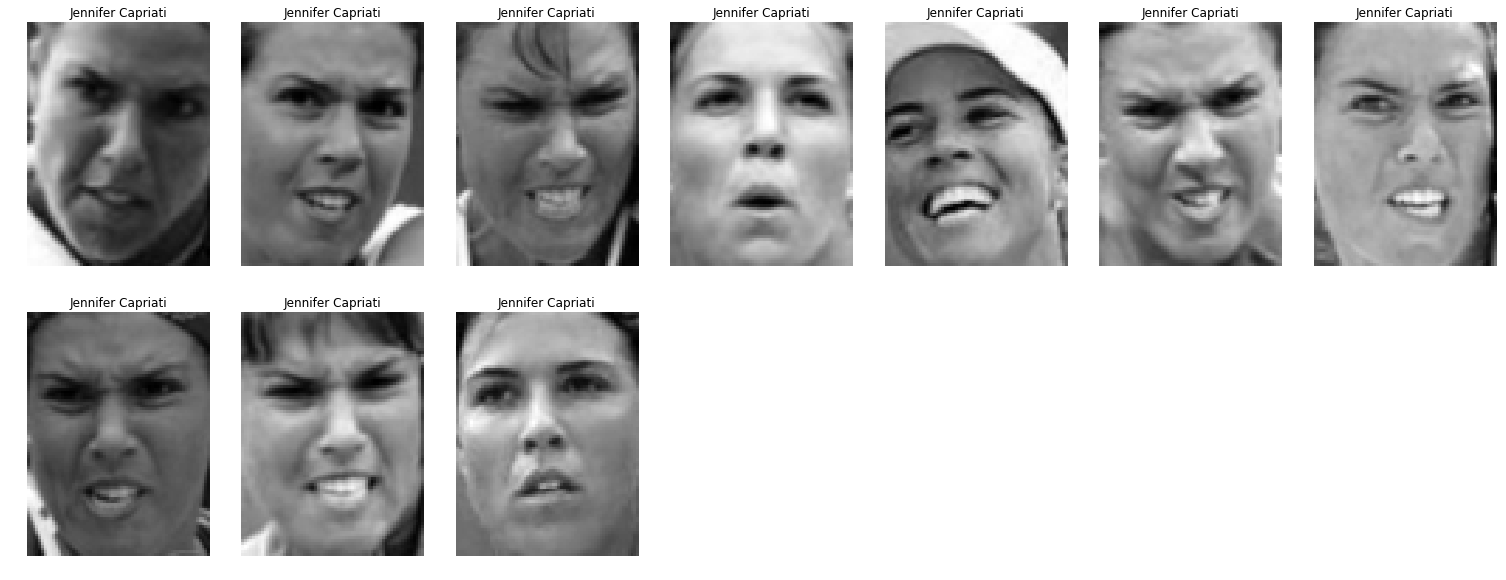

In [18]:
show_misclassified(4, 5, 2, 23)
show_misclassified(4, 5, 2, 23, True)
show_misclassified(4, 7, 23)

They not only do look alike, but also contain frowning photos. As they are both Tennis players, lots of photos of them seem to be taken during a match.

Let's see what photos of Mauressimo classfied correctly.

Faces of Amelie Mauresmo classified correctly:


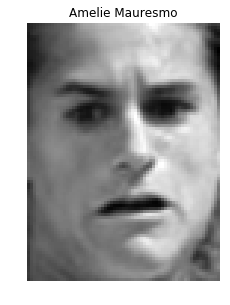

In [19]:
show_misclassified(4, 5, 2, 2)

It could be the shades this time too, but Capriati also have shady photos.


Text(0,0.5,'Accuracy')

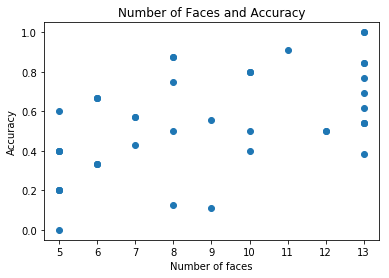

In [20]:
cm2 = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
num = np.zeros(45)
for i in range(45):
    num[i] = len(X_test[(y_test==i)])
fig = plt.figure()
plt.plot(num, np.diag(cm2), 'o')
plt.title('Number of Faces and Accuracy')
plt.xlabel('Number of faces')
plt.ylabel('Accuracy')

People with more number of faces tend to have higher accuracy, as expected.

## Conclusion
Both KNN and SVM are robust algorithms, despite their simplicity. However, it may perform differently in real life dataset. For example, coloured images with higher dataset or images with similar faces such as twins may result in lower accuracy or slower computation.

The confusion matrix indicates that the algorithm seems to struggle with images with similar facial expression and poor alignment. It also seems to be affected by the shades within the images. This indicates that a more advanced pre-processing algorithm may improve the performance significantly. Also, focusing on domain knowledge such as shape of eye, nose, chin etc. may increase the accuracy as the algorithm doesn't use the same metrics as humans use. As people with higher number of faces performed better, gathering more data may also help.

With cutting edge, propreietary ML algorithms, facial recognition algorithm that is as accurate as human brain may be achievable. Facebook’s facial recognition project, DeepFace, has achieved the accuracy of 97.25%. Humans can perform same task with 97.53% accuracy.

## Acknowledgements
I would like to thank Prof. David A. Stephens for this opportunity to research and his assitance through the research.

## References
[1] Müller, Andreas C., and Sarah Guido. *Introduction to machine learning with Python: a guide for data scientists*. 1st ed., O'Reilly, 2017.<br>
[2] Raschka, Sebastian, and Vahid Mirjalili. *Python machine learning: machine learning and deep learning with Python, scikit-Learn, and TensorFlow*. 2nd ed., Packt Publishing, 2017.<br>
[3] Hastie, Trevor, et al. “The Elements of Statistical Learning.” *Data Mining, Inference*, | *Trevor Hastie* | Springer, Springer-Verlag New York, www.springer.com/us/book/9780387848570.